# Collection person locations within frame and building a csv dataset

### Notebook 3 

In this notebook I will take the progress in using the model to identify pedestrians within frame and build a datat set of pedestrian location within a single frame.

By logging the coordinates within the following frame I'll attempt to link that coordinates that have moved very slightly will likely be from the pedestrian in the previous frame.

From this I will build a csv data set to use for future location predicition

In [1]:
import os
import sys
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
import cv2
import json
import re

%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.path.abspath("../")
print("Root Directory: ", ROOT_DIR)
sys.path.append(ROOT_DIR)

from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

from scripts import coco
from scripts import list_file_info as lfi
from scripts import video_to_frames as vtf

Root Directory:  /home/sam/Documents/GitHub/honoursProject/PedestrianDetectionSGall


In [2]:
data_root = "/home/sam/Desktop/sam_bdd_videos/videos_for_frames/"

file_list = os.listdir(path = data_root) 
max = len(file_list) 

if max == 0:
    print("No video folders in directory")
else:
    print("please select video from 1 to " + str(max))

please select video from 1 to 4


In [3]:
# Select a video 

selected_video = 4

vid_dir = "/home/sam/Desktop/sam_bdd_videos/videos_for_frames/" + str(selected_video) + "/video/"
frames_dir = "/home/sam/Desktop/sam_bdd_videos/videos_for_frames/" + str(selected_video) + "/frames/"
final_vid_dir = "/home/sam/Desktop/sam_bdd_videos/videos_for_frames/" + str(selected_video) + "/output_vid/"
output_dir = "/home/sam/Desktop/sam_bdd_videos/videos_for_frames/" + str(selected_video) + "/output_img/"
json_output_dir = "/home/sam/Desktop/sam_bdd_videos/videos_for_frames/" + str(selected_video) + "/output_json/"

In [4]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0

In [5]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "weights/mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
                'bus', 'train', 'truck', 'boat', 'traffic light',
                'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
                'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
                'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
                'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
                'kite', 'baseball bat', 'baseball glove', 'skateboard',
                'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
                'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
                'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
                'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
                'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
                'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
                'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
                'teddy bear', 'hair drier', 'toothbrush']

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [6]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

print("Loading weights ", COCO_MODEL_PATH)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

2022-03-23 18:59:47.339253: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-23 18:59:47.379768: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-23 18:59:47.379928: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-23 18:59:47.380388: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Instructions for updating:
Use fn_output_signature instead
Loading weights  /home/sam/Documents/GitHub/honoursProject/PedestrianDetectionSGall/weights/mask_rcnn_coco.h5


In [7]:
# Get video file name 

vid_name = lfi.get_file_name(vid_dir)

video_path = vid_dir + vid_name
print(video_path)

/home/sam/Desktop/sam_bdd_videos/videos_for_frames/4/video/73a4bd1e-bfe891e6.mov


In [8]:
# Check if frames exist and if not break video into frames

frame_list = os.listdir(path = frames_dir) 
max = len(frame_list) 

if max == 0:
    vtf.getFrames(video_path, frames_dir)
    print("Video broken down to frames")
    frame_list = os.listdir(path = frames_dir)
    max = len(frame_list) 
else:
    print("frames already exist")

print("You can select from frame 0 to " + str(max - 1))

frames already exist
You can select from frame 0 to 1201


In [9]:
# Create collection for frame names in frames_dir

frames_list = lfi.get_file_names(frames_dir)

# Sort the frames into accending order

frames_list.sort(key=lambda f: int(re.sub('\D', '', f)))

/home/sam/Desktop/sam_bdd_videos/videos_for_frames/4/frames/500.jpg
{'object 0': {'pedestrian 0': ('Y1 = ', 185, 'X1 = ', 1156, 'Y2 = ', 531, 'X2 = ', 1276, 'Accuracy = ', 0.99814427)}}


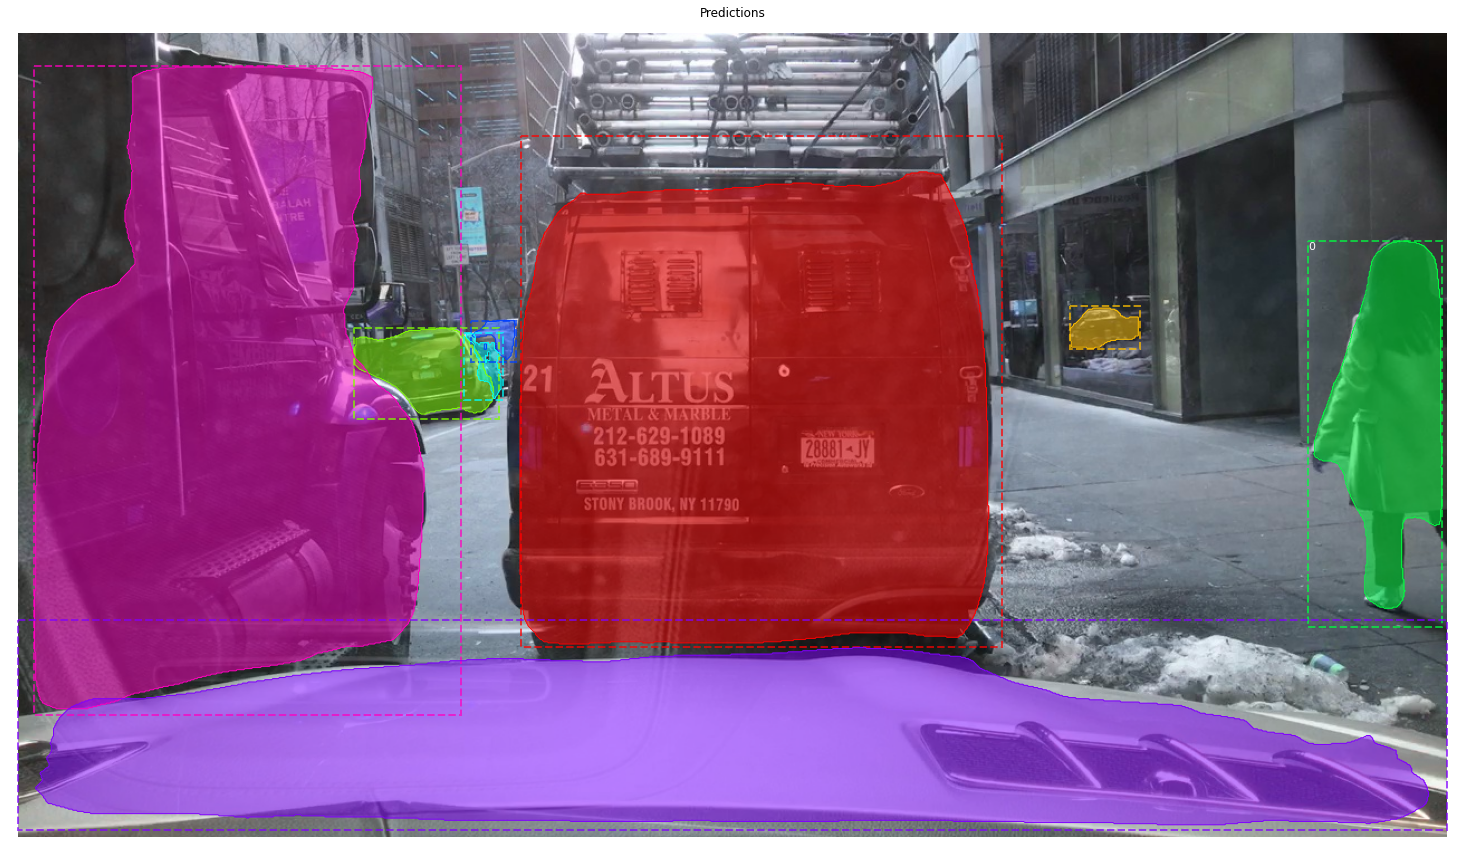

In [12]:
image_path = os.path.join(frames_dir,frames_list[500])

print(image_path)

image = cv2.imread(image_path)

_, ax = plt.subplots(1, figsize=(26, 26))

height, width = image.shape[:2]

# Run object detection
results = model.detect([image], verbose=0)

# Display results
r = results[0]

labels = []

frame_data = dict()

i = 0

j = 0

for id in r['class_ids']:
    
    if r['class_ids'][i] == 1:
        
        labels.append(str(j))
        
        frame_data[i] = {'object ' + str(i) : {'pedestrian ' + str(j): ('Y1 = ', r['rois'][i][0],
                                                                        'X1 = ', r['rois'][i][1],
                                                                        'Y2 = ', r['rois'][i][2],
                                                                        'X2 = ', r['rois'][i][3], 
                                                                        'Accuracy = ', r['scores'][i])}}
        
        j += 1
        
    else:
        labels.append(' ')
    
    i += 1

for fd in frame_data:
    print(frame_data[fd])

image_ir = visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'], ax=ax, title="Predictions", captions=labels)

/home/sam/Desktop/sam_bdd_videos/videos_for_frames/4/frames/501.jpg
{'object 0': {'pedestrian 0': ('Y1 = ', 184, 'X1 = ', 1142, 'Y2 = ', 532, 'X2 = ', 1278, 'Accuracy = ', 0.9990791)}}


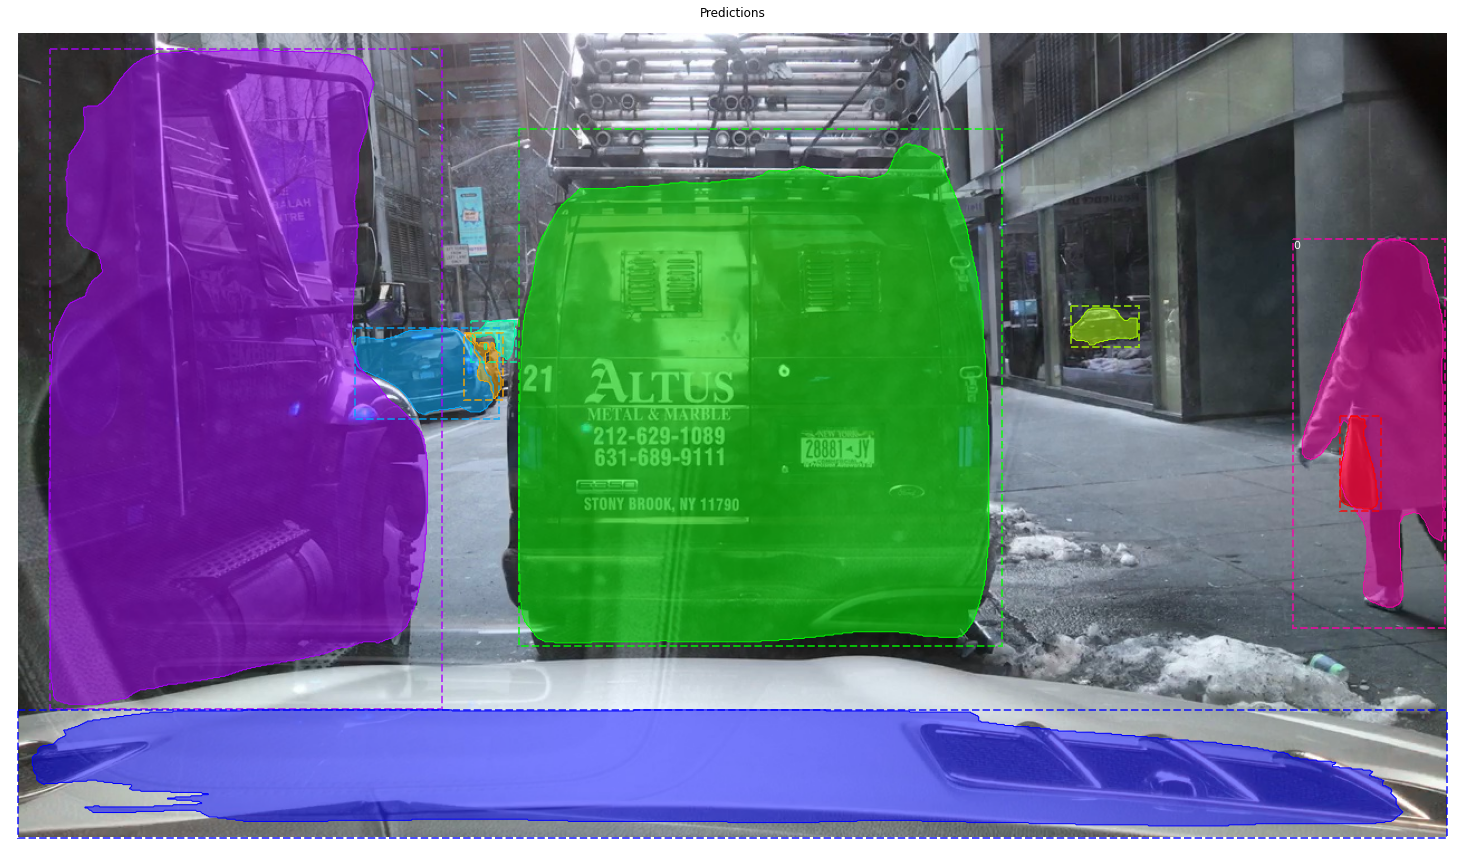

In [13]:
image_path = os.path.join(frames_dir,frames_list[501])

print(image_path)

image = cv2.imread(image_path)

_, ax = plt.subplots(1, figsize=(26, 26))

height, width = image.shape[:2]

# Run object detection
results = model.detect([image], verbose=0)

# Display results
r = results[0]

labels = []

frame_data = dict()

i = 0

j = 0

for id in r['class_ids']:
    
    if r['class_ids'][i] == 1:
        
        labels.append(str(j))
        
        frame_data[i] = {'object ' + str(i) : {'pedestrian ' + str(j): ('Y1 = ', r['rois'][i][0],
                                                                        'X1 = ', r['rois'][i][1],
                                                                        'Y2 = ', r['rois'][i][2],
                                                                        'X2 = ', r['rois'][i][3], 
                                                                        'Accuracy = ', r['scores'][i])}}
        
        j += 1
        
    else:
        labels.append(' ')
    
    i += 1

for fd in frame_data:
    print(frame_data[fd])

image_ir = visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'], ax=ax, title="Predictions", captions=labels)